# Beijing Air Quality Forecasting Starter Notebook

In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error

In [62]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Time_Series_Forecasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Time_Series_Forecasting/test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [64]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [65]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [66]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [67]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [68]:
X_train = train.drop(['pm2.5', 'No'], axis=1).to_numpy()
y_train = train['pm2.5'].to_numpy()

In [79]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped using the Sliding Window Technique
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [80]:
# define model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, activation='tanh'),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 24, 128)             │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - lambda: 118.2350 - loss: 14294.2197 - val_lambda: 106.8767 - val_loss: 16956.0547
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - lambda: 102.7911 - loss: 10849.0088 - val_lambda: 96.8348 - val_loss: 14339.4043
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - lambda: 93.4673 - loss: 8986.2539 - val_lambda: 92.5156 - val_loss: 12593.2100
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step - lambda: 91.7189 - loss: 7785.7183 - val_lambda: 90.0820 - val_loss: 11443.6650
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - lambda: 87.8944 - loss: 6699.2305 - val_lambda: 88.9505 - val_loss: 10715.3252
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - lambda: 89.9849 - loss: 6440.4277 - val_lambda: 89.0995 - val_loss: 9538.3105
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - lambda: 92.7079 - loss: 5621.6582 - val_lambda: 89.4062 - val_loss: 8701.9414
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/ste

958/958 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step


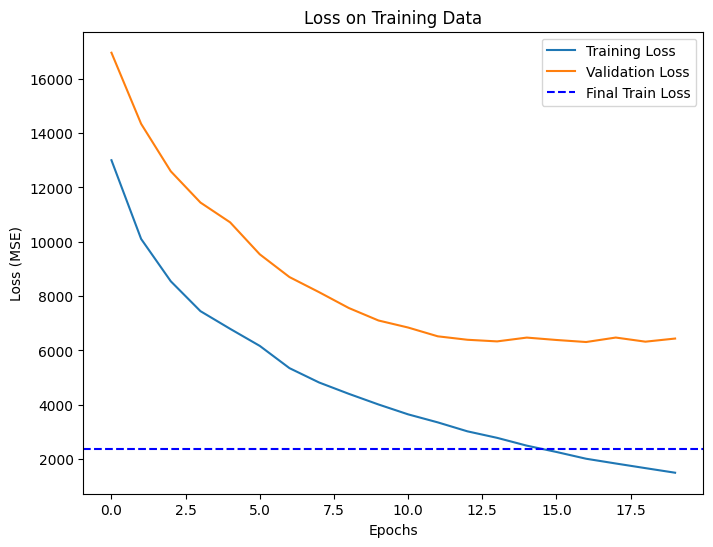

Final Training Loss (MSE): 2389.39475537231
Final Training RMSE: 48.881435692625786


In [76]:
# Calculate training loss
train_predictions = model.predict(X_train_seq)
train_loss = np.mean((y_train_seq - train_predictions.flatten()) ** 2)
train_rmse = np.sqrt(mean_squared_error(y_train_seq, train_predictions.flatten()))

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training RMSE: {train_rmse}")

In [78]:
# Prepare the test data
X_test = test.drop(['No'], axis=1).to_numpy()  # Convert to NumPy array

# Create sequences for the test data
X_test_seq = []
for i in range(len(X_test) - seq_length + 1):
    X_test_seq.append(X_test[i:i+seq_length])
X_test_seq = np.array(X_test_seq)

# Make predictions on the test set
predictions = model.predict(X_test_seq)
predictions = np.nan_to_num(predictions)  # Handle NaN values
predictions = np.round(predictions).astype(int)  # Convert to integers

# Prepare the submission file
# Create a DataFrame with all timestamps from the test data
full_submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S')
})

# Align predictions with the correct timestamps
# The predictions correspond to the last timestamp in each sequence
prediction_timestamps = pd.to_datetime(test.index[seq_length-1:]).strftime('%Y-%m-%d %-H:%M:%S')
prediction_df = pd.DataFrame({
    'row ID': prediction_timestamps,
    'pm2.5': predictions.flatten()
})

# Merge the predictions with the full timestamps
full_submission = full_submission.merge(prediction_df, on='row ID', how='left')

# Fill missing predictions with a default value (e.g., 0)
full_submission['pm2.5'].fillna(0, inplace=True)

# Sort the submission by 'row ID'
full_submission = full_submission.sort_values(by='row ID')

# Check the number of rows in the submission
print(f"Number of rows in submission: {len(full_submission)}")

# Save the file in CSV format for submission on Kaggle
full_submission.to_csv('/content/subm_fixed12.csv', index=False)

print("Submission file saved successfully!")

411/411 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step
Number of rows in submission: 13148
Submission file saved successfully!


<ipython-input-78-7ab7d993acf1>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_submission['pm2.5'].fillna(0, inplace=True)
